In [1]:
import numpy as np
import pandas as pd
import json
import sys
import os
import matplotlib
# matplotlib.use('Agg') 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
import pdb
#import ipdb
import h5py
import importlib
import pickle
import math

# Add root folder to sys path
sys.path.append("../")

from load_expert_traj import recursively_save_dict_contents_to_group

# %pylab inline
# inline doesn't give interactive plots
# %matplotlib inline 
# %matplotlib notebook
plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'Blues'

sns.set()

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

# Import own modules
# Need to use importlib since module starts with a numerical value.

# Utils for drawing circle

In [2]:
def draw_circle(centre, omega, r, direction=1, T = 120, theta_offset = 0):
    c_x = centre[0]
    c_y = centre[1]
    theta_offset = math.radians(theta_offset)
    
    list_of_points = []
    
    old_x = c_x + r * math.cos(theta_offset)
    old_y = c_y + r * math.sin(theta_offset)
    list_of_points.append((old_x, old_y))
    
    for t in range(1, T):
        theta = math.radians(omega * t * direction)
        new_x = c_x + r * math.cos(theta + theta_offset)
        new_y = c_y + r * math.sin(theta + theta_offset)
        
        del_x = new_x - old_x # normalize these to unit vectors to get actions
        del_y = new_y - old_y
        
        old_x = new_x
        old_y = new_y
        list_of_points.append((old_x, old_y))
        
    return list_of_points       

In [3]:

def draw_trajectory_for_4_half_circles(r_list, direction_list, plot=True):
    center_list_x = [-5. + (i + 1)* 5 / 4. for i in range(4)]
    T_list = [int(120 / 4) for _ in range(4)]
    omega_list = [1.5 * 4 for _ in range(4)]
    # centre1 = (-2.5, 0.0)
    # w1, T1 = 3 , 60
    # circle_1 = draw_circle(centre = centre1, omega = w1, r = r1, direction=direction1, T = T1, theta_offset = 180)

    # # centre2 = (0.0, -(r1+r2))
    # # centre2 = (circle_1[0][0], circle_1[0][1] + r2)
    # centre2 = (2.5, 0.0)
    # w2, T2 = 3, 60
    # circle_2 = draw_circle(centre = centre2, omega = w2, r = r2, direction=direction2, T = T2, theta_offset = 180)
    
    x_list = []
    y_list = []
    shift_x = 0.
    shift_y = 0.
    for center_id in range(len(center_list_x)):
        circle_1 = draw_circle(centre = (center_list_x[center_id], 0.0), omega = omega_list[center_id], r = r_list[center_id], direction=direction_list[center_id], T = T_list[center_id], theta_offset = 180)
        if center_id != 0:
            shift_x = circle_1[0][0] - x_list[-1]
            shift_y = circle_1[0][1] - y_list[-1]
        for i in range(1, len(circle_1)):
            x_list.append(circle_1[i][0] - shift_x)  
            y_list.append(circle_1[i][1] - shift_y) 
    
    
    if plot:
        colors = cm.rainbow(np.linspace(0, 1, len(x_list)))
        plt.scatter(x_list, y_list, color=colors, s=8) 
        plt.axis('equal')    
        plt.title("Policy 1: R: {}, R2".format(r_list))

    return x_list, y_list

def draw_trajectory_for_two_half_circles(r1=2.5, r2=2.5, direction1=1, direction2=-1, plot=True):
    centre1 = (-2.5, 0.0)
    w1, T1 = 3 , 60
    circle_1 = draw_circle(centre = centre1, omega = w1, r = r1, direction=direction1, T = T1, theta_offset = 180)

    # centre2 = (0.0, -(r1+r2))
    # centre2 = (circle_1[0][0], circle_1[0][1] + r2)
    centre2 = (2.5, 0.0)
    w2, T2 = 3, 60
    circle_2 = draw_circle(centre = centre2, omega = w2, r = r2, direction=direction2, T = T2, theta_offset = 180)
    
    x_list = []
    y_list = []
    for i in range(len(circle_1)):
        x_list.append(circle_1[i][0])
        y_list.append(circle_1[i][1])
    shift_x = circle_2[0][0] - x_list[-1]
    shift_y = circle_2[0][1] - y_list[-1]
    
    for i in range(1, len(circle_2)):
        x_list.append(circle_2[i][0] - shift_x)
        y_list.append(circle_2[i][1] - shift_y)
    
    if plot:
        colors = cm.rainbow(np.linspace(0, 1, len(x_list)))
        plt.scatter(x_list, y_list, color=colors, s=8) 
        plt.axis('equal')    
        plt.title("Policy 1: R1: {:.2f}, R2: {:2f}".format(r1, r2))

    return x_list, y_list

def draw_trajectory_for_one_circle(r=5.0, direction=1, plot=True, center=(0.0,0.0), sel_func=None):
    centre1 = center
    w1, T1 = 1.5 , 120
    circle_1 = draw_circle(centre = centre1, omega = w1, r = r, direction=direction, T = T1, theta_offset = 180)
    
    x_list = []
    y_list = []
    if sel_func is None:
        for i in range(len(circle_1)):
            x_list.append(circle_1[i][0])
            y_list.append(circle_1[i][1])
    elif sel_func == 'up':
        for i in range(len(circle_1)):
            if circle_1[i][1] > 0.:
                x_list.append(circle_1[i][0])
                y_list.append(circle_1[i][1])
    elif sel_func == 'down':
        for i in range(len(circle_1)):
            if circle_1[i][1] < 0.:
                x_list.append(circle_1[i][0])
                y_list.append(circle_1[i][1])

    if plot:
        colors = cm.rainbow(np.linspace(0, 1, len(x_list)))
        plt.scatter(x_list, y_list, color=colors, s=8) 
        plt.axis('equal')    
        plt.title("Policy 2: R: {:.2f}".format(r))

    return x_list, y_list



# From circle to action

In [4]:
def get_state_action_from_positions(pos_x_list, pos_y_list):
    # states are (x, y) actions are (delta_x, delta_y)
    states, actions = [], []
    for i in range(len(pos_x_list)):
        states.append((pos_x_list[i], pos_y_list[i]))
    for i in range(1, len(states)):
        a0 = states[i][0] - states[i-1][0]
        a1 = states[i][1] - states[i-1][1]
        a = [a0, a1] / np.linalg.norm([a0, a1])
        actions.append(a)
    # Remove the last state
    return states[:-1], actions

# Generate Ntimes with different policy:

In [5]:
def gen_policy4_Ntimes_to_dict(expert_data_dict, num_traj=5):
    # Get trajectories for policy 2 circle (10 trajectories)
    radius = 1.25
    r1_arr = np.random.normal(radius, 0.02, 10)
    direction_list = [None for _ in range(4)]
    
    for i in range(num_traj):
        r_list = [np.random.choice(r1_arr) for _ in range(4)]
        direction_1 = np.random.choice([1, -1])
        direction_list[0] = direction_1
        direction_list[2] = direction_1
        direction_list[1] = -direction_1 # opposite circles 
        direction_list[3] = -direction_1 # opposite circles 
        # r2, r3 = r1, r1
        # r2 = np.random.choice(r2_arr)
        # r3 = np.random.choice(r3_arr)
        states_x, states_y = draw_trajectory_for_4_half_circles(r_list, direction_list, plot=True)
        states, actions = get_state_action_from_positions(states_x, states_y)
        key = '{}_p1_{}'.format(i, r_list)
        expert_data_dict[key] = {}
        expert_data_dict[key]['state'] = np.array(states)
        expert_data_dict[key]['action'] = np.array(actions)
        expert_data_dict[key]['goal'] = np.ones(len(actions))
        expert_data_dict[key]['radius'] = np.array(r_list)

def gen_policy2_Ntimes_to_dict(expert_data_dict, num_traj=5):
    # Get trajectories for policy 2 circle (10 trajectories)
    r1_arr = np.random.normal(2.5, 0.05, 10)
    r2_arr = np.random.normal(2.5, 0.05, 10)
    direction = [1, -1]
    for i in range(num_traj):
        r1 = np.random.choice(r1_arr)
        r2 = np.random.choice(r2_arr)
        direction_1 = np.random.choice([1, -1])
        direction[0] = direction_1
        direction[1] = -direction_1 # opposite circles 
        # r2, r3 = r1, r1
        # r2 = np.random.choice(r2_arr)
        # r3 = np.random.choice(r3_arr)
        states_x, states_y = draw_trajectory_for_two_half_circles(
            r1=r1, r2=r2, direction1=direction[0], direction2=direction[1], plot=True)
        states, actions = get_state_action_from_positions(states_x, states_y)
        key = '{}_p1_{:.2f}_{:.2f}'.format(i, r1, r2)
        expert_data_dict[key] = {}
        expert_data_dict[key]['state'] = np.array(states)
        expert_data_dict[key]['action'] = np.array(actions)
        expert_data_dict[key]['goal'] = np.ones(len(actions))
        expert_data_dict[key]['radius'] = np.array([r1, r2])

def gen_policy1_Ntimes_to_dict(expert_data_dict, num_traj=5):
    # generate trajectories for one_circle
    r_arr = np.random.normal(5.0, 0.2, 10)
    for i in range(num_traj):
        r = np.random.choice(r_arr)
        direction = np.random.choice([1, -1])
        states_x, states_y = draw_trajectory_for_one_circle(
            r=r, direction=direction, plot=True)
        states, actions = get_state_action_from_positions(states_x, states_y)
        key = '{}_p2_{:.2f}'.format(i, r)
        expert_data_dict[key] = {}
        expert_data_dict[key]['state'] = np.array(states)
        expert_data_dict[key]['action'] = np.array(actions)
        expert_data_dict[key]['goal'] = np.ones(len(actions))
        expert_data_dict[key]['radius'] = np.array([r])


# Generate circle 4_2

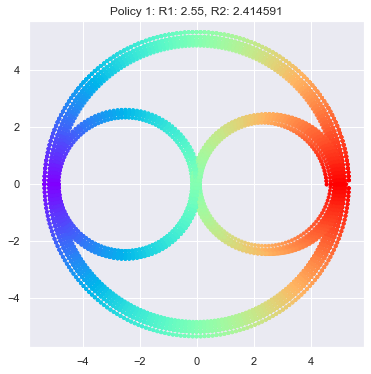

{'0_p2_4.92': {'state': array([[-4.92288675e+00,  6.02879750e-16],
       [-4.92119980e+00, -1.28866152e-01],
       [-4.91614010e+00, -2.57643985e-01],
       [-4.90771113e+00, -3.86245243e-01],
       [-4.89591866e+00, -5.14581786e-01],
       [-4.88077077e+00, -6.42565662e-01],
       [-4.86227784e+00, -7.70109155e-01],
       [-4.84045255e+00, -8.97124853e-01],
       [-4.81530986e+00, -1.02352571e+00],
       [-4.78686699e+00, -1.14922509e+00],
       [-4.75514345e+00, -1.27413685e+00],
       [-4.72016097e+00, -1.39817538e+00],
       [-4.68194352e+00, -1.52125567e+00],
       [-4.64051730e+00, -1.64329336e+00],
       [-4.59591071e+00, -1.76420483e+00],
       [-4.54815431e+00, -1.88390720e+00],
       [-4.49728083e+00, -2.00231843e+00],
       [-4.44332513e+00, -2.11935737e+00],
       [-4.38632421e+00, -2.23494381e+00],
       [-4.32631712e+00, -2.34899854e+00],
       [-4.26334498e+00, -2.46144337e+00],
       [-4.19745096e+00, -2.57220126e+00],
       [-4.12868022e+00, -2.68

In [15]:


def save_expert_traj_dict_to_h5(traj_data_dict, save_dir,
                               h5_filename='expert_traj.h5'):
     h5_f = h5py.File(os.path.join(save_dir, h5_filename), 'w')
     recursively_save_dict_contents_to_group(h5_f, '/', traj_data_dict)
     h5_f.flush()
     h5_f.close()
     print("Did save data to {}".format(os.path.join(save_dir, h5_filename)))


# r3_arr = np.random.normal(2, 0.5, 10)

expert_data_dict = {}


num_traj = 50
gen_policy1_Ntimes_to_dict(expert_data_dict=expert_data_dict, num_traj=num_traj)
gen_policy2_Ntimes_to_dict(expert_data_dict=expert_data_dict, num_traj=num_traj)
plt.savefig('circle.png')
plt.show()

env_data_dict = {'num_goals': 4, 'num_actions': 2}
data_to_save = {
    'expert_traj': expert_data_dict,
    'env_data': env_data_dict,
}
print(expert_data_dict)
SAVE_DATA = False
if SAVE_DATA:
    import os
    save_dir = f'../h5_trajs/circle_trajs/meta_42_traj_{2 * num_traj}_circles'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_expert_traj_dict_to_h5(data_to_save, save_dir)

# Generate circle 8_4_2



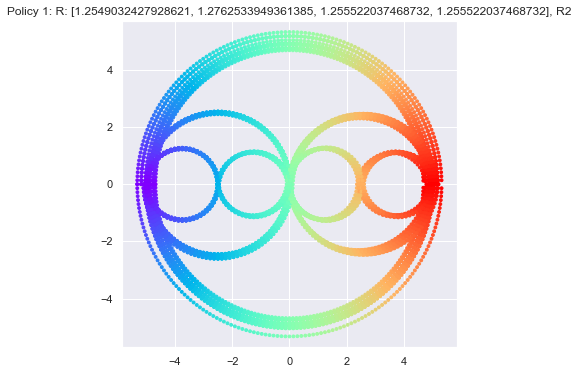

<HDF5 dataset "num_goals": shape (), type "<i8">
8
<HDF5 dataset "num_actions": shape (), type "<i8">
2
Did save data to ../h5_trajs/circle_trajs/meta_842_traj_90_circles/expert_traj.h5


In [6]:


def save_expert_traj_dict_to_h5(traj_data_dict, save_dir,
                               h5_filename='expert_traj.h5'):
     h5_f = h5py.File(os.path.join(save_dir, h5_filename), 'w')
     recursively_save_dict_contents_to_group(h5_f, '/', traj_data_dict)
     h5_f.flush()
     h5_f.close()
     print("Did save data to {}".format(os.path.join(save_dir, h5_filename)))

# Get trajectories for policy 1 (10 trajectories)
num_traj = 30
r1_arr = np.random.normal(2.5, 0.1, 10)
r2_arr = np.random.normal(2.5, 0.1, 10)
direction = [1, -1]
# r3_arr = np.random.normal(2, 0.5, 10)

env_data_dict = {'num_goals': 8, 'num_actions': 2}
expert_data_dict = {}
gen_policy1_Ntimes_to_dict(expert_data_dict=expert_data_dict, num_traj=num_traj)
gen_policy2_Ntimes_to_dict(expert_data_dict=expert_data_dict, num_traj=num_traj)
gen_policy4_Ntimes_to_dict(expert_data_dict=expert_data_dict, num_traj=num_traj)
plt.savefig('circle.png')
plt.show()


data_to_save = {
    'expert_traj': expert_data_dict,
    'env_data': env_data_dict,
}
# print(expert_data_dict)
SAVE_DATA = True
if SAVE_DATA:
    import os
    save_dir = f'../h5_trajs/circle_trajs/meta_842_traj_{3 * num_traj}_circles'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_expert_traj_dict_to_h5(data_to_save, save_dir)